# Task

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. 
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет  https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

# Libs

In [1]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from IPython import display

import torch
from torch.utils.data import DataLoader

from torch import nn
from torch import optim

import torchvision.transforms.functional as F
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

# Base vars

In [2]:
ROOT_DIR = '..\\data\\leapGestRecog'
PATH_TO_MODEL = '..\\models\\gesture_detection_model_state.pth'

IMG_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 100

BATCH_POINT = 10

MAX_LR = 1e-4

# Load and preprocessing data

In [3]:
"""transformation settings"""

train_transforms = tt.Compose([
    tt.Resize((IMG_SIZE, IMG_SIZE)),
    tt.ColorJitter((0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (-0.5, 0.5)),
    tt.Grayscale(num_output_channels=1), # Картинки чернобелые
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(45), # Случайные повороты на 30 градусов
    tt.ToTensor(),
])

train_dataset = ImageFolder(ROOT_DIR + '\\train', train_transforms)

trainDataLoader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)

# View data

In [4]:
class_names = trainDataLoader.dataset.classes
class_names

['fist', 'no_gest', 'ok', 'palm']

size 1 batch: torch.Size([64, 1, 64, 64])
count lbls: torch.Size([64])


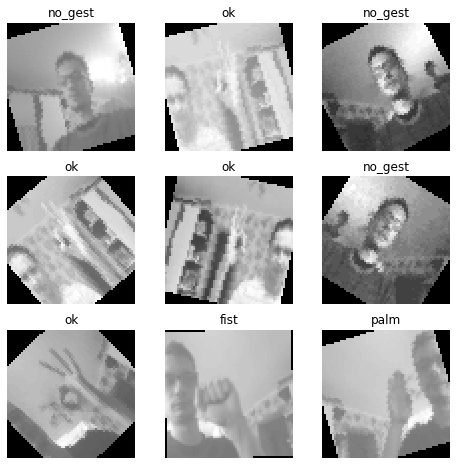

In [5]:
plt.figure(figsize=(8,8))

for batch, labels in trainDataLoader:
    
    print(f'size 1 batch: {batch.shape}')
    print(f'count lbls: {labels.shape}')
    
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(batch[i, 0])
        plt.gray()
        plt.title(class_names[labels[i]])
        plt.axis('off')
        
    break

# Learning model

In [6]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(
            self.conv_block(128, 128), 
            self.conv_block(128, 128)
        ) # Sequential
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(
            self.conv_block(256, 256), 
            self.conv_block(256, 256)
        ) # Sequential
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(
            self.conv_block(512, 512), 
            self.conv_block(512, 512)
        ) # Sequential
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(6), 
            nn.Flatten(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        ) # Sequential
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: 
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [7]:
"""init model"""

model = ResNet(1, len(class_names))

"""loading model state"""

try:
    model.load_state_dict(torch.load(PATH_TO_MODEL))
    print('model state loaded')
except FileNotFoundError as err:
    print(err)

model state loaded


In [8]:
"""init model params"""

optimizer = optim.Adam(model.parameters(), MAX_LR)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    MAX_LR,
    epochs=EPOCHS,
    steps_per_epoch=len(trainDataLoader)
) # OneCycleLR

In [9]:
print(f'{EPOCHS} epochs, {len(trainDataLoader)} total_steps per epoch')

100 epochs, 27 total_steps per epoch


In [10]:
epoch_losses = []

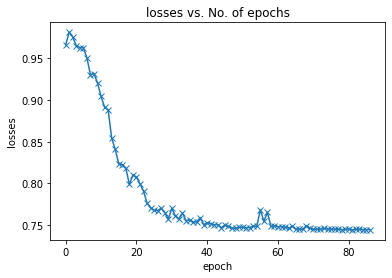

	Batch 10, Loss: 0.7442868530750275
	Spend time for 10 batches: 137.98885130882263 sec
	Batch 20, Loss: 0.7441030383110047
	Spend time for 10 batches: 139.37414455413818 sec


KeyboardInterrupt: 

In [11]:
for epoch in range(EPOCHS):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    
    for batch_idx, (data, labels) in enumerate(trainDataLoader):     
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
        _, preds = torch.max(outputs, 1)
        
        loss = nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
        if (batch_idx+1) % BATCH_POINT == 0:
            
            torch.save(model.state_dict(), PATH_TO_MODEL)

            print(f'\tBatch {batch_idx+1}, Loss: {running_loss/BATCH_POINT}')
            time2 = time.time()

            print(f'\tSpend time for {BATCH_POINT} batches: {time2 - time1} sec')
            time1 = time.time()

            running_loss = 0.0

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    
    display.clear_output(wait=False)
    
    losses = [np.mean(loss) for loss in epoch_losses]
    
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.title('losses vs. No. of epochs')
    plt.show()